In [ ]:
import pandas as pd
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Import Vector System Log .csv files from the Optimus Portal and concatenate into pandas dataframe

all_files = glob.glob("/VS_data/*.csv")  
df_from_each_file = (pd.concat([pd.read_csv(f), pd.DataFrame([0])], ignore_index=True) for f in all_files)
all_data = pd.concat(df_from_each_file, ignore_index=True)

In [ ]:
# Parse data, extract the following information as dictionaries: 
# Vehicle state: 2 (diesel), 3 (warming up), or 4(biodiesel)
# Start time and end time of each state
# Ambient temperature
# B100 fuel temperature

data_array = []
j = 0
for index, row in all_data.iterrows():
  start_time = all_data.iloc[j]['Timestamp(UTC)']
  state = all_data.iloc[j]['Vehicle_State']
  temp = all_data.iloc[j]['Ambient_Temp(F)']
  if (all_data.iloc[index]['Vehicle_State'] != all_data.iloc[index - 1]['Vehicle_State']) or (all_data.iloc[index]['Timestamp(UTC)'][:10] != all_data.iloc[index - 1]['Timestamp(UTC)'][:10]):
    end_time = all_data.iloc[index - 1]['Timestamp(UTC)']
    fuel_temp_in = all_data.iloc[index-1]['Fuel_Temp_In(F)']
    fuel_temp_out = all_data.iloc[index-1]['Fuel_Temp_Out(F)']
    data_array.append({"state": state, "start time": start_time, "end time": end_time, "temp": temp, "fuel_temp_in": fuel_temp_in, "fuel_temp_out": fuel_temp_out})
    j = index

In [ ]:
# Filter out data entries that are not cold start (first start of the day)
def startup_only(array):
  dates = {}
  new_array = []
  full_array = []
  i = 0
  while i < len(array):
    d = array[i]
    start = str(d['start time'])[:10]
    if start not in dates:
      dates[start] = 1
      new_array.append(d)
    elif dates[start] < 3:
      dates[start] += 1
      new_array.append(d)
    i += 1
  return new_array

In [ ]:
start_array = startup_only(data_array[1:])

In [ ]:
# Filter out entries that are not the full warmup sequence from state 2 to state 3 to state 4
# Returns data entries that reflect full warmup transition from diesel to biodiesel
def filter(array):
  filtered = []
  i = 0
  while (i < len(array)-2):
    if (array[i]['state'] == 2.0) and (array[i+1]['state'] == 3.0) and (array[i+2]['state'] == 4.0):
      filtered.append(array[i])
      filtered.append(array[i+1])
      filtered.append(array[i+2])
      i += 3
    else:
      i += 1
  return filtered

In [ ]:
# This function filters the data array to keep all 2-to-3 state sequences (i.e. VS begins warming up biodiesel but does not necessarily switch over)
def filter_23(array):
  filtered = []
  i = 0
  while (i < len(array)-2):
    if (array[i]['state'] == 2.0) and (array[i+1]['state'] == 3.0) and (array[i+2]['state'] != 4.0):
      filtered.append(array[i])
      filtered.append(array[i+1])
      # filtered.append(array[i+2])
      i += 2
    else:
      i += 1
  return filtered

In [ ]:
# Translates start and end times for each state into the time spent in each state
def translate(array):
  translated = []
  for d in array:
    s = d['start time']
    e = d['end time']
    start_time = datetime.datetime(year=int(s[:4]), month=int(s[5:7]), day=int(s[8:10]), hour=int(s[11:13]), minute=int(s[14:16]), second=int(s[17:19]))
    end_time = datetime.datetime(year=int(e[:4]), month=int(e[5:7]), day=int(e[8:10]), hour=int(e[11:13]), minute=int(e[14:16]), second=int(e[17:19]))
    delta = end_time - start_time
    translated.append({'state': d['state'], 'duration': delta.seconds/60, 'temp': d['temp'], 'fuel_temp_in': d['fuel_temp_in'], 'fuel_temp_out': d['fuel_temp_out']})
  return translated

In [ ]:
final_23 = translate(filter_23(start_array))

In [ ]:
final = translate(filter(start_array))

In [ ]:
# Data points indicating full transition from diesel to biodiesel
i = 0
xpoints = []
ypoints = []
while i < len(final):
  if final[i]['temp'] == 0:
    xpoints.append(final[i+1]['temp'])
  else:
    xpoints.append(final[i]['temp'])
  ypoints.append(final[i]['duration']+final[i+1]['duration']) # Total time spent in state 2 and 3
  i += 3

# plt.plot(xpoints, ypoints, linestyle = '', marker = 'o')
# plt.show()

In [ ]:
# Data points indicating biodiesel warmup started but not necessarily completed/successful
i = 0
xpoints2 = []
ypoints2 = []
while i < len(final_23):
  if final_23[i]['temp'] == 0:
    xpoints2.append(final_23[i+1]['temp'])
  else:
    xpoints2.append(final_23[i]['temp'])
  ypoints2.append(final_23[i]['duration']+final_23[i+1]['duration']) # Total time spent in state 2 and 3
  i += 2

# plt.plot(xpoints2, ypoints2, linestyle = '', marker = 'o')
# plt.show()

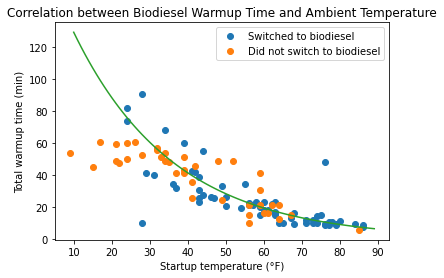

In [ ]:
# These extra data points were added based on operator log data, not included in the VS log files:
xpoints += [28,24,39,34,24]
ypoints += [91,82,60,68,74]

plt.plot(xpoints, ypoints, linestyle = '', marker = 'o')
plt.plot(xpoints2, ypoints2, linestyle = '', marker = 'o')
x = np.arange(10,90)
plt.plot(x, 189.38*np.exp(-0.038*x)) #exponential (R^2=0.88048)
plt.legend(["Switched to biodiesel", "Did not switch to biodiesel"])#,"Estimated time to switch from data"])
plt.title("Correlation between Biodiesel Warmup Time and Ambient Temperature")
plt.xlabel("Startup temperature (°F)")
plt.ylabel("Total warmup time (min)")

plt.show()

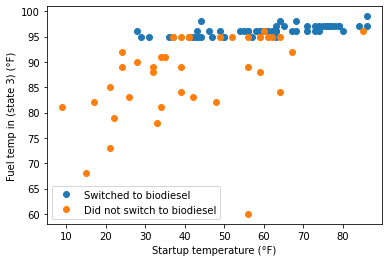

In [ ]:
# Plot biodiesel fuel temperatures to compare the temperatures between warmup transition (state 3) and using biodiesel (state 4)
i = 0
xpoints3 = []
ypoints3 = []
while i < len(final_23):
  xpoints3.append(final_23[i]['temp'])
  ypoints3.append(final_23[i+1]['fuel_temp_in']) 
  i += 2

j = 0
xpoints4 = []
ypoints4 = []
while j < len(final):
  xpoints4.append(final[j]['temp'])
  ypoints4.append(final[j+1]['fuel_temp_in']) 
  j += 3

plt.plot(xpoints4, ypoints4, linestyle = '', marker = 'o')
plt.plot(xpoints3, ypoints3, linestyle = '', marker = 'o')
plt.legend(["Switched to biodiesel", "Did not switch to biodiesel"])
plt.xlabel("Startup temperature (°F)")
plt.ylabel("Fuel temp in (state 3) (°F)")

plt.show()

In [ ]:
# Use the warmup time correlation to predict the expected VS warmup time for each month in Ithaca based on average montly temperature
def prediction(temp):
  return 189.38*np.exp(-0.038*temp)

jan = np.mean([27.9,16.5])
feb = np.mean([30.9,17.8])
mar = np.mean([39.9,25.0])
apr = np.mean([52.7,35.2])
may = np.mean([66.6,46.2])
jun = np.mean([73.0,52.5])
jul = np.mean([78.8,57.7])
aug = np.mean([76.5,55.9])
sep = np.mean([70.0,50.7])
oct = np.mean([57.0,41.9])
nov = np.mean([44.1,31.5])
dec = np.mean([33.6,24.1])

temps = {'Jan':jan, 'Feb':feb, 'Mar':mar, 'Apr':apr, 'May':may, 'Jun':jun, 'Jul':jul, 'Aug':aug, 'Sep':sep, 'Oct':oct, 'Nov':nov, 'Dec':dec}

for k in temps:
  print(k+':',"Average Temperature:", str(temps[k])+"° F;", prediction(temps[k]), "min")

Jan: Average Temperature: 22.2° F; 81.46354165924485 min
Feb: Average Temperature: 24.35° F; 75.07259498732132 min
Mar: Average Temperature: 32.45° F; 55.18303552239061 min
Apr: Average Temperature: 43.95° F; 35.646664445982 min
May: Average Temperature: 56.4° F; 22.210287413674347 min
Jun: Average Temperature: 62.75° F; 17.448533038540372 min
Jul: Average Temperature: 68.25° F; 14.157656576438315 min
Aug: Average Temperature: 66.2° F; 15.304632778653398 min
Sep: Average Temperature: 60.35° F; 19.114659974068687 min
Oct: Average Temperature: 49.45° F; 28.923533698049184 min
Nov: Average Temperature: 37.8° F; 45.031199806195474 min
Dec: Average Temperature: 28.85° F; 63.2728026318118 min
